<a href="https://colab.research.google.com/github/yigitates17/DSAI-Assignments/blob/main/DSAI544_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>## Assignment 1 - DSAI 544 Computer Vision With Machine Learning






>Student's Name: *WRITE YOUR NAME HERE*

* The full assignment is worth 15 points in total. Please write your answers within the correct exercise sections.
* Please sumbit your .ipynb file to Moodle before due time.
* Files should be named in the following format: DSAI544 Assignment 1 Name Surname
* You must run your code, the outputs (especially from test codes) will be important in the grading process. There are somes codes to test your code, use them to test your solution, and make sure to keep those codes and their printouts.

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
import torchvision
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose(
    [
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
cifar10 = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transform)

batch_size = 32
n = batch_size
dataloader = DataLoader(cifar10, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_test = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:12<00:00, 13606761.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Backprop Your Own Gradients

In this section you will backprop your gradients through a loss function. Below you fill find an implementation of a loss function in multiple steps, an integrated loss function implementation and finally a partial implementation of an autograd function.

Your taks is to implement the backward passes for these functions and verify that your implementation is correct. This section will teach you how to write your own custom differentiable loss function and how to implement it in a way that fits in with standard pytorch classes.

In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def compare(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
model = nn.Sequential(
    # Conv2d( in_channels, out_channels, kernel_size) B,3,32,32
    nn.Conv2d(3, 32, 3, stride= 2, padding=1),  nn.BatchNorm2d(32), nn.Tanh(), # B,32,16,16
    nn.Conv2d(32, 64, 3, stride= 2, padding=1), nn.BatchNorm2d(64), nn.Tanh(), # B,32,8,8
    nn.Conv2d(64, 128, 3, stride= 2, padding=1), nn.BatchNorm2d(128), nn.Tanh(), # B,32,4,4
    nn.Flatten(),
    nn.Linear(4*4*128, 64), nn.BatchNorm1d(64), nn.Tanh(),
    nn.Linear(64, 10)
)

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001)

In [ ]:
batch = next(iter(dataloader))
x = batch[0]
y = batch[1]

logits = model(x)

### **Exercise 1: Writing backward pass**

*4 Points*

Backprop through the loss function manually, backpropagating through exactly all of the variables as they are defined in the forward pass below, one by one starting from the end and propagating to the beginning.

I have included notes and clues that will help you in backpropogation. Keep in mind that a derrivative for a variable should be the same shape as the orignal variable. Remember that if there is a broadcast operation in the forward pass you need to have a summing operation in the backward pass and if there is a summation in the forward pass you need to have a broadcast operation in the backward pass.

In [ ]:
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), y].mean()

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits]:
  t.retain_grad()

optim.zero_grad()
loss.backward()
loss

tensor(2.5485, grad_fn=<NegBackward0>)

In [ ]:
# ----------------------
# Write your answer here

# You should consider which parts of the logprops is affecting the loss
# Only backpropagate the gradients to those elements
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), y] = -1.0/n * 1

# d/dx(log(x))= 1/x
dprobs = (1/probs) * dlogprobs

# Broadcasing in forward means summation in backward
dcounts_sum_inv = None

# d/dx(1/x) = -x**-2
dcounts_sum = None

# Remember that there are counts is used both for counts_sum and probs
# so it should have 2 additive contributions
# Remember that summation in forward pass is broadcasting in backward pass
dcounts = None

# d/dx(e^x)= e^x
dnorm_logits = None

# d/dx(-x)= -1 and broadcasing in forward means summation in backward
dlogit_maxes = None

# Remember that there are counts is used both for logit_maxes and norm_logits
# so it should have 2 additive contributions
# For the first component remember d/dx(x)= 1
# For the second component remember to only affect the indices have max values
dlogits = None
# ----------------------

#YOU WILL USE THE COMPARE FUNCTIONS BELOW TO SEE IF YOU HAVE THE CORRECT SOLUTION OR NOT
#ALSO THEY WILL BE USED IN THE GRADING PROCESS, RUN THEM ALL AND KEEP THEIR PRINTOUTS
compare('logprobs', dlogprobs, logprobs)
compare('probs', dprobs, probs)
#compare('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
#compare('counts_sum', dcounts_sum, counts_sum)
#compare('counts', dcounts, counts)
#compare('norm_logits', dnorm_logits, norm_logits)
#compare('logit_maxes', dlogit_maxes, logit_maxes)
#compare('logits', dlogits, logits)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0


### **Exercise 2: Simplifying Cross-Entropy Expression**

*2 points*

Backprop through cross_entropy function in one step. Look at the mathematical expression for cross entropy $-\sum_{c=1}^{10}y_{c}\log(p_c)$, calculate the derivative analytically (with pen and paper) and finally write down the simplified expression for the backpropagation calculation.

Remember that in order to convert the logits into propabilities $p$ we need to take the softmax. Since the labels are one-hot only the labels that are correct are going to affect the final loss $L$ and the expression for cross entropy can be simplified to
$L=-log(\frac{e^{logit_y}}{\sum_{j}e^{logit_j}})$.

Take the derivative of the loss with respect to the each dimension of the logit $logit_i$. Remember that you can simplify the experssion by considering two cases. One where $i=y$ and one where $i\neq y$.

Finally remember that we are calculating the loss over the batches and we need to average the losses over the batch dimension (i.e. divide by batch_size)

Note: Your answer don't have to produce the exactly same result as the Pytorch implementation you can get an approximately correct version that has less max difference than 1e-8.

In [ ]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum)
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, y)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

2.3596858978271484 diff: -2.384185791015625e-07


In [ ]:
# ----------------------
# Write your answer here

dlogits = None

# ----------------------
#THE CODE BELOW AND IT'S OUTPUT WILL BE USED IN THE GRADING PROCESS
#USE IT TO TEST YOUR SOLUTION
compare('logits', dlogits, logits) # It is ok to get approximate correctness, 1e-8 is OK

logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


### **Exercise 3: Defining new Autograd function**

*2 points*

Now use your solution from the previous step to write a custom autograd Function. You can take a look at the [documententation](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html) for autograd functions in order to get a clearer idea.

For the forward pass we have already provided the implementation steps. You don't need to backpropagate the loss with respect to the labels they are return with None in the template



In [ ]:
class CustomCrossEntropy(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, logits, y):
        """CustomCrossEntropy.apply
        Here we save the elements necessary for calculating the backward pass.
        We than use the efficient expression for the backward pass.
        """
        ctx.save_for_backward(logits, y)
        return F.cross_entropy(logits, y)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        We first load the tensors that we have saved before
        Calculate the local derivative and backpropagate it by multiplying the upstream
        derivative with the local derivative. You don't need to backpropagate the gradient
        for y and return None since we expect it to be a fixed value.
        """
        logits, y, = ctx.saved_tensors

        # ----------------------
        # Write your answer here

        return ???, None
        # ----------------------

Below is a check for you to make sure that your code has been implemented correctly.

In [ ]:
#THE CODE BELOW AND IT'S OUTPUT WILL BE USED IN THE GRADING PROCESS
#USE IT TO TEST YOUR SOLUTION
batch = next(iter(dataloader))
x = batch[0]
y = batch[1]

# Calculate loss and gradients using Pytorch CrossEntropy method
logits = model(x)
loss = F.cross_entropy(logits, y)

logits.retain_grad()

optim.zero_grad()
loss.backward()

pytorch_logits_grad = logits.grad

print("pytorch cross entropy loss: ",loss)

# Calculate loss using new CustomCrossEntropy method
logits = model(x)
loss_fn = CustomCrossEntropy.apply
loss = loss_fn(logits, y)

logits.retain_grad()

optim.zero_grad()
loss.backward()

custom_logits_grad = logits.grad
print("custom cross entropy loss: ",loss)

torch.allclose(custom_logits_grad, pytorch_logits_grad)

pytorch cross entropy loss:  tensor(2.3533, grad_fn=<NllLossBackward0>)
custom cross entropy loss:  tensor(2.3533, grad_fn=<CustomCrossEntropyBackward>)


True

## Exercise 3b — Debug Softmax + Cross-Entropy (Forward & Backward)

*2 points*

**Goal:** Fix a deliberately wrong implementation of **softmax + cross-entropy** so that:
1) it’s numerically stable  
2) the reduction in forward matches the scaling in backward  
3) your manual gradient w.r.t. logits matches PyTorch autograd.

**What’s wrong down below?**

The forward and backward procedures (`almost_correct_ce_forward()` & `almost_correct_ce_backward()`) of a loss function is designed by some beginner PyTorch enthusiast 😎 However he has done a little mistake in his definitions.   
The procedure is as follows:
- computed the loss via `softmax` + `-log(...)` (unstable),  
- took a **sum** in the forward, but divided by **N** in the backward (mismatch),  
- skipped using `log_softmax`.

**What is **your** task?**
- Replace the wrong forward/backward with a correct, stable formulation using `log_softmax`.
- Ensure the forward reduction (e.g., `"mean"`) matches the gradient scaling.
- Pass the unit tests that compare your manual gradient to `torch.nn.functional.cross_entropy`.

### Hints

- Correct logits-gradient for Cross-Entropy with softmax (mean reduction) is:

    dL/dz = (p − one_hot(y)) / N

    where:
    
    • p = softmax(z)

    • z = logits

    • y = target class index

    • N = batch size

- Use the stable version of log-softmax to compute the loss:

    log_probs = F.log_softmax(logits, dim=1)

- Don't forget:

    • If you use "sum" reduction → do NOT divide the gradient by N  

    • If you use "mean" reduction → do divide the gradient by N  



In [ ]:
# Wrongly Written Reference (DO NOT MODIFY HERE)
# ------------------------------------------------------------
def almost_correct_ce_forward(logits: torch.Tensor, targets: torch.Tensor, reduction: str = "mean") -> torch.Tensor:
    """
      - uses softmax + log, not log_softmax (numerical issues)
      - uses SUM reduction regardless, then the "reduction" arg is half-respected
    """
    N, C = logits.shape
    probs = torch.softmax(logits, dim=1)  # unstable when logits have large magnitude
    nll = -torch.log(probs[torch.arange(N), targets] + 1e-12)  # add eps, but still poor stability
    if reduction == "none":
        return nll
    elif reduction == "mean":
        return nll.sum()
    elif reduction == "sum":
        return nll.sum()
    else:
        raise ValueError("reduction must be 'none' | 'mean' | 'sum'")

def almost_correct_ce_backward(logits: torch.Tensor, targets: torch.Tensor, reduction: str = "mean") -> torch.Tensor:
    """
      - gradient formula assumes mean reduction (divides by N),
        even if forward did .sum()
    """
    N, C = logits.shape
    probs = torch.softmax(logits, dim=1)
    grad = probs.clone()
    grad[torch.arange(N), targets] -= 1.0
    if reduction == "none":
        grad = grad / N
    elif reduction == "mean":
        grad = grad / N
    elif reduction == "sum":
        grad = grad / N
    return grad


Now please implement your fix:

In [ ]:
# Your fix: Implement a numerically stable CE
# ------------------------------------------------------------
def my_ce_forward(logits: torch.Tensor, targets: torch.Tensor, reduction: str = "mean") -> torch.Tensor:
"""
"""
    # ======= YOUR CODE STARTS HERE =======

    # ======= YOUR CODE ENDS HERE =======


def my_ce_backward(logits: torch.Tensor, targets: torch.Tensor, reduction: str = "mean") -> torch.Tensor:
"""
"""
    # ======= YOUR CODE STARTS HERE =======

    # ======= YOUR CODE ENDS HERE =======


Now test your fix please:

In [ ]:
# Unit tests: Compare to PyTorch's F.cross_entropy
# ------------------------------------------------------------
def check_grad_match(reduction: str = "mean", seed: int = 7, verbose=True):
    torch.manual_seed(seed)
    N, C = 8, 5
    logits = torch.randn(N, C, requires_grad=True)
    targets = torch.randint(0, C, (N,))

    # PyTorch reference
    ref_loss = F.cross_entropy(logits, targets, reduction=reduction)
    # Provide a gradient tensor for non-scalar outputs
    grad_tensor = torch.ones_like(ref_loss) if reduction == "none" else None
    ref_loss.backward(gradient=grad_tensor)
    ref_grad = logits.grad.detach().clone()

    # Your manual grad (ensure fresh graph/grad)
    logits2 = logits.detach().clone().requires_grad_(True)
    my_loss = my_ce_forward(logits2, targets, reduction=reduction)
    # Backward using our manual gradient injection (stop autograd, compare tensors)
    manual_grad = my_ce_backward(logits2.detach(), targets, reduction=reduction)
    # Check shape & finite
    assert manual_grad.shape == logits2.shape and torch.isfinite(manual_grad).all(), "Manual grad invalid."
    # Compare with autograd's grad for the SAME forward loss
    # (Call backward on logits2 with manual grad like a hook equivalence)
    logits2.backward(manual_grad, retain_graph=False)  # gradient injection
    my_grad = logits2.grad.detach().clone()

    # Because CE is convex in logits, the true grad of CE wrt logits equals (softmax - one_hot)/reduction
    # We compare derived grads numerically:
    mae = (my_grad - ref_grad).abs().mean().item()
    if verbose:
        print(f"[reduction={reduction}] mean |Δgrad| vs PyTorch autograd: {mae:.6e}")
    assert mae < 1e-6, f"Gradient mismatch too large (MAE={mae}); fix your forward/backward."

    # Compare loss values too
    with torch.no_grad():
        l_ref = ref_loss.item() if reduction != "none" else ref_loss.mean().item()
        l_stu = my_ce_forward(logits.detach(), targets, reduction=reduction).item() if reduction != "none" else my_ce_forward(logits.detach(), targets, reduction=reduction).mean().item()
    if verbose:
        print(f"[reduction={reduction}] ref_loss={l_ref:.6f}  my_loss={l_stu:.6f}")
    assert abs(l_ref - l_stu) < 1e-6, "Loss value mismatch; check your forward reduction/stability."

# Expect these to PASS after you fix student_ce_forward/backward:
for red in ["none", "mean", "sum"]:
    check_grad_match(reduction=red)
print("All reductions matched autograd.")

[reduction=none] mean |Δgrad| vs PyTorch autograd: 6.821938e-09
[reduction=none] ref_loss=1.746523  my_loss=1.746523
[reduction=mean] mean |Δgrad| vs PyTorch autograd: 8.527422e-10
[reduction=mean] ref_loss=1.746523  my_loss=1.746523
[reduction=sum] mean |Δgrad| vs PyTorch autograd: 6.821938e-09
[reduction=sum] ref_loss=13.972184  my_loss=13.972184
All reductions matched autograd.


***Expected output:***

[reduction=none] mean |Δgrad| vs PyTorch autograd: 6.821938e-09

[reduction=none] ref_loss=1.746523  my_loss=1.746523

[reduction=mean] mean |Δgrad| vs PyTorch autograd: 8.527422e-10

[reduction=mean] ref_loss=1.746523  my_loss=1.746523

[reduction=sum] mean |Δgrad| vs PyTorch autograd: 6.821938e-09

[reduction=sum] ref_loss=13.972184  my_loss=13.972184

All reductions matched autograd.

## Architecture Optimization

### **Exercise 4: Convolutional Architecture**

*5 points*

Below you find the model definition for a Convolutional neural network. Your task is to optimize the network architecture below to improve the model performance. **The minimum criteria for success is %85 validation accuracy.** Please share your training setup including your architecture and any other modifications you have made on the discussion section opened on Moodle. **Three students who has the highest accuracy among you will get 2 extra points to their final course score.**

You are free to use other components like MaxPool2d, Dropout and ReLU from torch.nn library. Please remember the architectural innovations and regularization methods mentioned in the class and try to emulate them here. You can also change augmentation, learning rate schedulers and optimization methods as you like. **Don't use predefined models (such as ResNet, VGG etc.) right away but you can reimplement them yourselves**.

You can define blocks and bottleneck layers to define your architecture.

In [ ]:
model = nn.Sequential(
    # Conv2d( in_channels, out_channels, kernel_size) B,3,32,32
    nn.Conv2d(3, 32, 3, stride= 2, padding=1),  nn.BatchNorm2d(32), nn.Tanh(), # B,32,16,16
    nn.Conv2d(32, 64, 3, stride= 2, padding=1), nn.BatchNorm2d(64), nn.Tanh(), # B,32,8,8
    nn.Conv2d(64, 128, 3, stride= 2, padding=1), nn.BatchNorm2d(128), nn.Tanh(), # B,32,4,4
    nn.Flatten(),
    nn.Linear(4*4*128, 64), nn.BatchNorm1d(64), nn.Tanh(),
    nn.Linear(64, 10)
)

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001)

In [ ]:
i = 0
losses = []
steps = []
losses_t = []

lre = torch.linspace(-1, 4, 1000)
lrs = 10**lre

In [ ]:
for epoch in range(16):
  for batch in dataloader:
    i +=1
    x = batch[0].to('cuda')
    y = batch[1].to('cuda')
    model = model.to('cuda')

    logits = model(x)
    loss = F.cross_entropy(logits,y)
    optim.zero_grad()

    loss.backward()

    # optim.lr =  0.01 if i < 10000 else 0.001
    optim.param_groups[0]['lr'] = 0.01 if i < 10000 else 0.001
    # optim.lr = lrs[i]
    optim.step()

    losses.append(loss.item())
    losses_t.append(loss.detach())
    steps.append(i)

    if i % 1000 ==0:
      print(loss)

tensor(1.7877, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3352, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3915, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5391, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1766, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0968, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8771, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8672, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7921, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1581, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5354, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5144, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5785, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6723, device='cuda:0', grad_fn=

([<matplotlib.lines.Line2D at 0x7a8f1acdd9c0>], tensor(179.1650))

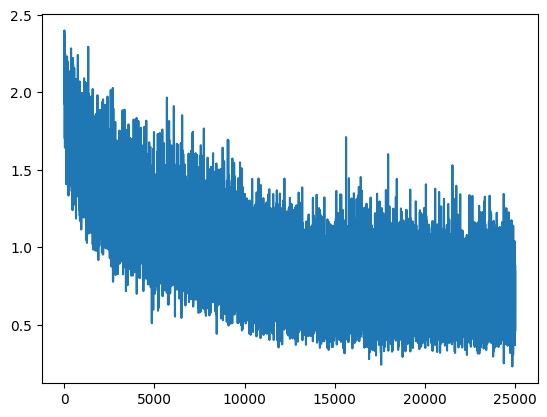

In [ ]:
plt.plot(steps, losses) , lrs[650]# , logits

In [ ]:
total_correct = 0
total_predictions = 0

# Loop over training dataset
for x_batch, y_batch in dataloader:
    logits = model(x_batch.to("cuda")) # Forward pass on the mini-batch
    loss = F.cross_entropy(logits.cpu(), y_batch) # Compute loss

    # Calculate predictions for the batch
    pred_labels = torch.max(logits, dim=1).indices

    # Update total correct predictions and total predictions
    total_correct += (y_batch == pred_labels.cpu()).sum().item()
    total_predictions += y_batch.size(0)

# Calculate overall accuracy
overall_accuracy = total_correct / total_predictions
print(f"Training Accuracy: {overall_accuracy}")

Training Accuracy: 0.76694


In [ ]:
total_correct = 0
total_predictions = 0

# Loop over testing dataset
for x_batch, y_batch in dataloader_test:
    logits = model(x_batch.to("cuda")) # Forward pass on the mini-batch
    loss = F.cross_entropy(logits.cpu(), y_batch) # Compute loss

    # Calculate predictions for the batch
    pred_labels = torch.max(logits, dim=1).indices

    # Update total correct predictions and total predictions
    total_correct += (y_batch == pred_labels.cpu()).sum().item()
    total_predictions += y_batch.size(0)

# Calculate overall accuracy and print it out.
overall_accuracy = total_correct / total_predictions
#DON'T FORGET TO PRINT OUT YOUR TESTING ACCURACY
print(f"Testting Accuracy: {overall_accuracy}")

Testting Accuracy: 0.6974
